<a href="https://colab.research.google.com/github/Alouach123/license-plate-detection-tracking/blob/main/licence_plate_detection_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ====================================================================
# CELLULE 1: Installation des dépendances
# ====================================================================

!pip install ultralytics roboflow opencv-python pillow matplotlib seaborn
!pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 34.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 86.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 94.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 M

In [ ]:
# ====================================================================
# CELLULE 2: Imports et configuration
# ====================================================================

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import yaml
from pathlib import Path
import shutil
from ultralytics import YOLO
import torch
import warnings
warnings.filterwarnings('ignore')

# Configuration
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Vérifier la disponibilité du GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device utilisé: {device}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Device utilisé: cuda


In [ ]:
# ====================================================================
# CELLULE 3: Téléchargement du dataset depuis Roboflow
# ====================================================================

from roboflow import Roboflow

# Initialisation de Roboflow
rf = Roboflow(api_key="svwGyZBEKjxz18nrqdWV")
project = rf.workspace("roboflow-universe-projects").project("license-plate-recognition-rxg4e")
version = project.version(11)

# Téléchargement du dataset
print("Téléchargement du dataset...")
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...
Téléchargement du dataset...



Extracting Dataset Version Zip to License-Plate-Recognition-11 in yolov11:: 100%|██████████| 20262/20262 [00:02<00:00, 7230.49it/s] 


In [ ]:
# ====================================================================
# CELLULE 4: Exploration du dataset
# ====================================================================

# Chemin vers le dataset
dataset_path = dataset.location
print(f"Dataset téléchargé dans: {dataset_path}")

# Structure du dataset
print("\nStructure du dataset:")
for root, dirs, files in os.walk(dataset_path):
    level = root.replace(dataset_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for file in files[:5]:  # Afficher seulement les 5 premiers fichiers
        print(f"{subindent}{file}")
    if len(files) > 5:
        print(f"{subindent}... et {len(files) - 5} autres fichiers")

Dataset téléchargé dans: /kaggle/working/License-Plate-Recognition-11

Structure du dataset:
License-Plate-Recognition-11/
  README.roboflow.txt
  README.dataset.txt
  data.yaml
  test/
    images/
      CarLongPlateGen1072_jpg.rf.6483f2d6d44372c983427ad79d77803a.jpg
      xemay238_jpg.rf.390dac8390f64426baf0d91aa06750b9.jpg
      CarLongPlateGen1974_jpg.rf.e398183309f830a6c0dd97d03b81b61c.jpg
      CarLongPlateGen1872_jpg.rf.65e8d5245871078d11476456af8ae5b6.jpg
      pic_689_jpg.rf.3faea35b11da2496639306a6e36eb737.jpg
      ... et 1015 autres fichiers
    labels/
      xemay2008_jpg.rf.dd2eec6de2890c588ef433edefe1384d.txt
      xemay1750_jpg.rf.931b095d68e24fb26d389b0bc6a04b11.txt
      xemay1544_jpg.rf.7572ac0f21fb33d0b309f39326b932da.txt
      CarLongPlateGen1565_jpg.rf.6527a356dfb02cea89dffd8945244ae8.txt
      CarLongPlateGen2883_jpg.rf.e022f274627899067e97ada873480f91.txt
      ... et 1015 autres fichiers
  train/
    images/
      CarLongPlateGen2451_jpg.rf.de232031c99689f2a7a5b


Statistiques du dataset:
train: 7057 images, 7057 labels
valid: 2048 images, 2048 labels
test: 1020 images, 1020 labels


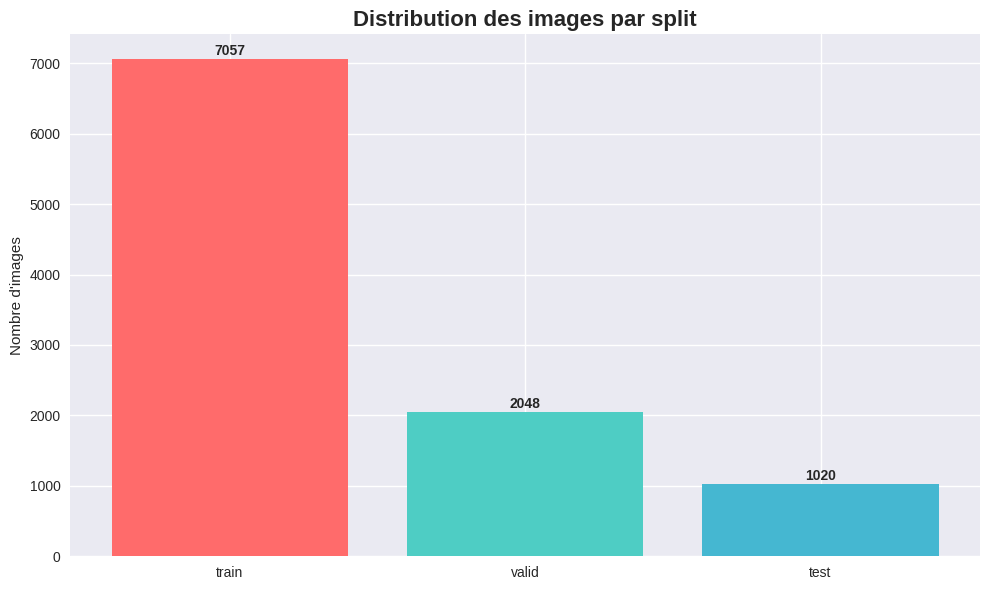

In [ ]:
# ====================================================================
# CELLULE 5: Analyse des données
# ====================================================================

def count_images_and_labels(dataset_path):
    """Compter les images et labels dans chaque split"""
    splits = ['train', 'valid', 'test']
    stats = {}

    for split in splits:
        images_path = os.path.join(dataset_path, split, 'images')
        labels_path = os.path.join(dataset_path, split, 'labels')

        if os.path.exists(images_path) and os.path.exists(labels_path):
            images = len([f for f in os.listdir(images_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
            labels = len([f for f in os.listdir(labels_path) if f.endswith('.txt')])
            stats[split] = {'images': images, 'labels': labels}
        else:
            stats[split] = {'images': 0, 'labels': 0}

    return stats

# Analyser le dataset
dataset_stats = count_images_and_labels(dataset_path)
print("\nStatistiques du dataset:")
for split, stats in dataset_stats.items():
    print(f"{split}: {stats['images']} images, {stats['labels']} labels")

# Visualisation des statistiques
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
splits = list(dataset_stats.keys())
image_counts = [dataset_stats[split]['images'] for split in splits]

bars = ax.bar(splits, image_counts, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax.set_title('Distribution des images par split', fontsize=16, fontweight='bold')
ax.set_ylabel('Nombre d\'images')

# Ajouter les valeurs sur les barres
for bar, count in zip(bars, image_counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 20,
            f'{count}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

Échantillons du dataset d'entraînement:


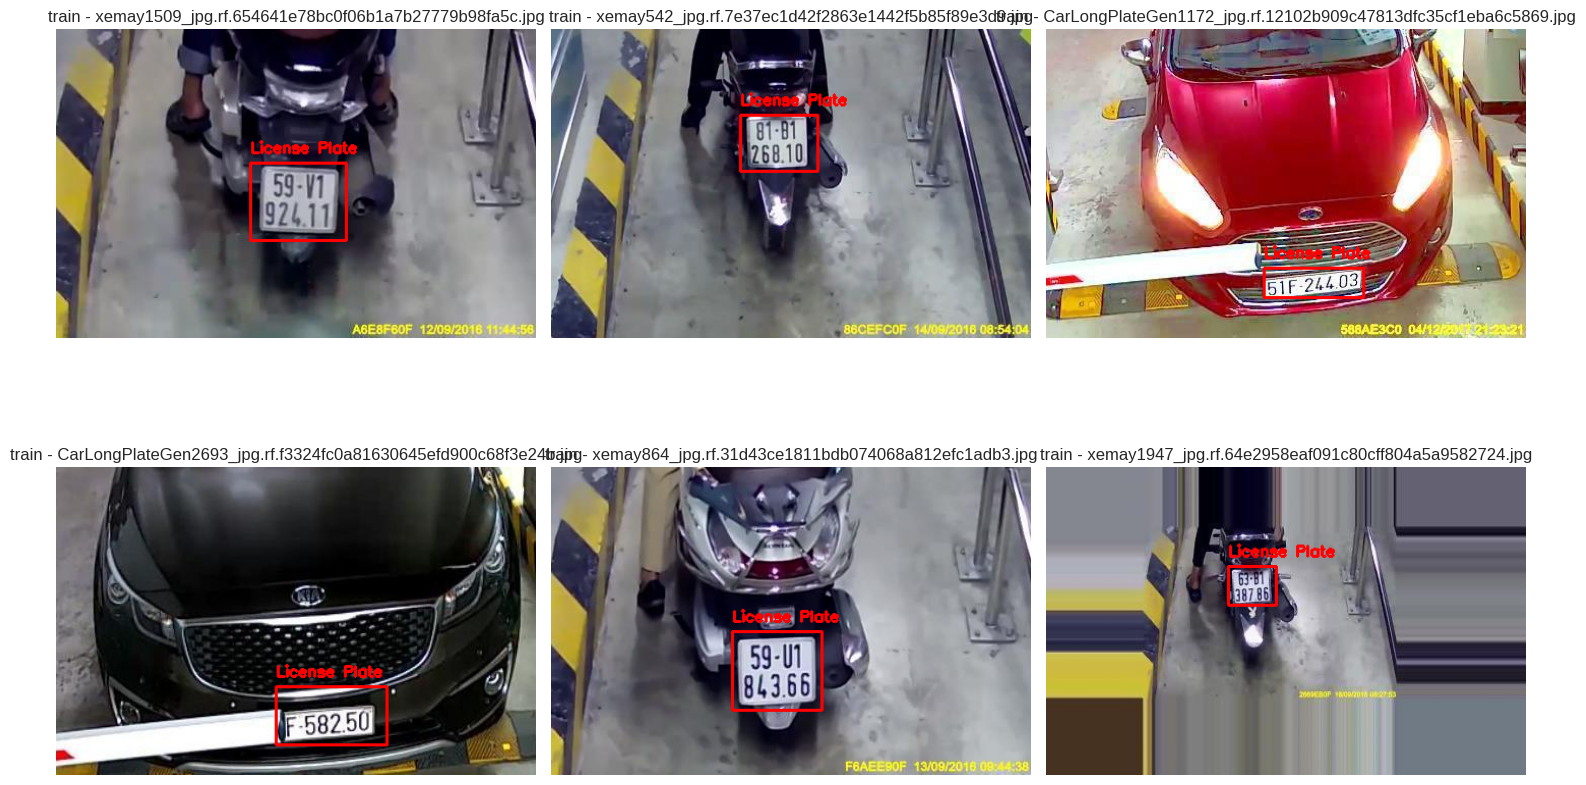

In [ ]:
# ====================================================================
# CELLULE 6: Visualisation d'échantillons d'images
# ====================================================================

def visualize_samples(dataset_path, split='train', num_samples=6):
    """Visualiser des échantillons d'images avec leurs annotations"""
    images_path = os.path.join(dataset_path, split, 'images')
    labels_path = os.path.join(dataset_path, split, 'labels')

    image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    selected_files = np.random.choice(image_files, min(num_samples, len(image_files)), replace=False)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i, img_file in enumerate(selected_files):
        # Charger l'image
        img_path = os.path.join(images_path, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Charger les annotations
        label_file = img_file.replace('.jpg', '.txt').replace('.png', '.txt').replace('.jpeg', '.txt')
        label_path = os.path.join(labels_path, label_file)

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()

            h, w = img.shape[:2]

            # Dessiner les bounding boxes
            for line in lines:
                parts = line.strip().split()
                if len(parts) >= 5:
                    class_id, x_center, y_center, width, height = map(float, parts[:5])

                    # Convertir les coordonnées YOLO en coordonnées pixel
                    x_center *= w
                    y_center *= h
                    width *= w
                    height *= h

                    x1 = int(x_center - width/2)
                    y1 = int(y_center - height/2)
                    x2 = int(x_center + width/2)
                    y2 = int(y_center + height/2)

                    # Dessiner le rectangle
                    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                    cv2.putText(img, 'License Plate', (x1, y1-10),
                              cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        axes[i].imshow(img)
        axes[i].set_title(f'{split} - {img_file}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Visualiser des échantillons
print("Échantillons du dataset d'entraînement:")
visualize_samples(dataset_path, 'train', 6)

In [ ]:
# ====================================================================
# CELLULE 7: Préparation de la configuration YAML
# ====================================================================

# Lire le fichier data.yaml existant
yaml_path = os.path.join(dataset_path, 'data.yaml')
if os.path.exists(yaml_path):
    with open(yaml_path, 'r') as f:
        config = yaml.safe_load(f)
    print("Configuration YAML existante:")
    print(yaml.dump(config, default_flow_style=False))
else:
    # Créer une configuration YAML si elle n'existe pas
    config = {
        'path': dataset_path,
        'train': 'train/images',
        'val': 'valid/images',
        'test': 'test/images',
        'nc': 1,
        'names': ['license_plate']
    }

    with open(yaml_path, 'w') as f:
        yaml.dump(config, f, default_flow_style=False)

    print("Configuration YAML créée:")
    print(yaml.dump(config, default_flow_style=False))

Configuration YAML existante:
names:
- License_Plate
nc: 1
roboflow:
  license: CC BY 4.0
  project: license-plate-recognition-rxg4e
  url: https://universe.roboflow.com/roboflow-universe-projects/license-plate-recognition-rxg4e/dataset/11
  version: 11
  workspace: roboflow-universe-projects
test: ../test/images
train: ../train/images
val: ../valid/images



In [ ]:
# ====================================================================
# CELLULE 8: Initialisation du modèle YOLOv12
# ====================================================================

# Charger le modèle YOLOv12
print("Chargement du modèle YOLOv12...")
try:
    # Essayer d'abord YOLOv12n (nano - plus rapide)
    model = YOLO('yolo11n.pt')  # YOLO11 est la version la plus récente disponible
    print("Modèle YOLO11n chargé avec succès")
except Exception as e:
    print(f"Erreur lors du chargement du modèle: {e}")
    # Fallback vers YOLOv8
    model = YOLO('yolov8n.pt')
    print("Modèle YOLOv8n chargé comme alternative")

# Afficher les informations du modèle
print(f"\nModèle chargé sur: {device}")
print(f"Nombre de paramètres: {sum(p.numel() for p in model.model.parameters()):,}")

Chargement du modèle YOLOv12...


100%|██████████| 5.35M/5.35M [00:00<00:00, 95.5MB/s]

Modèle YOLO11n chargé avec succès

Modèle chargé sur: cuda
Nombre de paramètres: 2,624,080


In [ ]:
# ====================================================================
# CELLULE 9: Entraînement du modèle
# ====================================================================

# Paramètres d'entraînement
training_params = {
    'data': yaml_path,
    'epochs': 75,
    'imgsz': 640,
    'batch': 16,
    'device': device,
    'workers': 4,
    'patience': 20,
    'save_period': 10,
    'project': 'license_plate_detection',
    'name': 'yolov12_training',
    'exist_ok': True,
    'pretrained': True,
    'optimizer': 'AdamW',
    'lr0': 0.01,
    'lrf': 0.01,
    'momentum': 0.937,
    'weight_decay': 0.0005,
    'warmup_epochs': 3,
    'warmup_momentum': 0.8,
    'box': 7.5,
    'cls': 0.5,
    'dfl': 1.5,
    'pose': 12.0,
    'kobj': 2.0,
    'augment': True,
    'verbose': True
}

print("Début de l'entraînement...")
print(f"Paramètres d'entraînement: {training_params}")

# Lancer l'entraînement
results = model.train(**training_params)

print("Entraînement terminé!")

Début de l'entraînement...
Paramètres d'entraînement: {'data': '/kaggle/working/License-Plate-Recognition-11/data.yaml', 'epochs': 75, 'imgsz': 640, 'batch': 16, 'device': 'cuda', 'workers': 4, 'patience': 20, 'save_period': 10, 'project': 'license_plate_detection', 'name': 'yolov12_training', 'exist_ok': True, 'pretrained': True, 'optimizer': 'AdamW', 'lr0': 0.01, 'lrf': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3, 'warmup_momentum': 0.8, 'box': 7.5, 'cls': 0.5, 'dfl': 1.5, 'pose': 12.0, 'kobj': 2.0, 'augment': True, 'verbose': True}
Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/License-Plate-Recognition-11/data.yaml, degrees=0.0, deterministic=True, device

100%|██████████| 755k/755k [00:00<00:00, 25.2MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/working/License-Plate-Recognition-11/train/labels... 7057 images, 5 backgrounds, 0 corrupt: 100%|██████████| 7057/7057 [00:05<00:00, 1380.42it/s]


train: New cache created: /kaggle/working/License-Plate-Recognition-11/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 329.2±129.8 MB/s, size: 20.8 KB)


val: Scanning /kaggle/working/License-Plate-Recognition-11/valid/labels... 2048 images, 3 backgrounds, 0 corrupt: 100%|██████████| 2048/2048 [00:01<00:00, 1094.03it/s]

val: New cache created: /kaggle/working/License-Plate-Recognition-11/valid/labels.cache


Plotting labels to license_plate_detection/yolov12_training/labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to license_plate_detection/yolov12_training
Starting training for 75 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/75      2.29G      1.437      1.164      1.298          1        640: 100%|██████████| 442/442 [01:22<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  5.17it/s]


                   all       2048       2195      0.159      0.435      0.125     0.0669

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/75      3.07G      1.406     0.9714      1.305          1        640: 100%|██████████| 442/442 [01:18<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  5.83it/s]

                   all       2048       2195      0.827      0.714      0.785      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/75      3.08G      1.355     0.8973      1.286          1        640: 100%|██████████| 442/442 [01:17<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  5.90it/s]

                   all       2048       2195      0.899      0.848      0.886      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/75       3.1G      1.316     0.8456      1.255          0        640: 100%|██████████| 442/442 [01:16<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:11<00:00,  5.73it/s]

                   all       2048       2195      0.876      0.852      0.875      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/75      3.11G      1.284      0.787      1.238          2        640: 100%|██████████| 442/442 [01:16<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:11<00:00,  5.71it/s]

                   all       2048       2195      0.917      0.839       0.89      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/75      3.13G      1.267     0.7571      1.218          4        640: 100%|██████████| 442/442 [01:16<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  6.02it/s]

                   all       2048       2195      0.934       0.86      0.907       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/75      3.14G      1.253     0.7368      1.212          3        640: 100%|██████████| 442/442 [01:16<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  6.00it/s]

                   all       2048       2195      0.931      0.886      0.918      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/75      3.16G       1.24     0.7227      1.212          3        640: 100%|██████████| 442/442 [01:16<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  5.83it/s]

                   all       2048       2195      0.948      0.873      0.931      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/75      3.17G      1.223     0.7074      1.195          1        640: 100%|██████████| 442/442 [01:16<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  6.02it/s]

                   all       2048       2195      0.962      0.895      0.939      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/75      3.19G      1.213     0.6813       1.19          1        640: 100%|██████████| 442/442 [01:16<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  5.97it/s]

                   all       2048       2195      0.952      0.889      0.933      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/75       3.2G      1.213     0.6829      1.189          4        640: 100%|██████████| 442/442 [01:16<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  5.87it/s]

                   all       2048       2195      0.952      0.907       0.94       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/75      3.21G      1.203     0.6668       1.18          2        640: 100%|██████████| 442/442 [01:16<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  6.10it/s]

                   all       2048       2195       0.98      0.905      0.947      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/75      3.23G      1.185     0.6498      1.169          4        640: 100%|██████████| 442/442 [01:16<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  5.99it/s]

                   all       2048       2195      0.963      0.907      0.942      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/75      3.25G      1.183     0.6441      1.171          2        640: 100%|██████████| 442/442 [01:16<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:11<00:00,  5.81it/s]

                   all       2048       2195      0.973      0.907      0.945      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/75      3.26G      1.182     0.6275      1.174          1        640: 100%|██████████| 442/442 [01:15<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  6.04it/s]

                   all       2048       2195      0.962      0.906      0.946      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/75      3.28G      1.174     0.6277      1.165          1        640: 100%|██████████| 442/442 [01:16<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  6.07it/s]

                   all       2048       2195      0.969      0.911      0.955      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/75      3.29G      1.168     0.6259      1.158          3        640: 100%|██████████| 442/442 [01:16<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  5.86it/s]

                   all       2048       2195      0.968      0.909      0.948      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/75       3.3G      1.167     0.6165       1.16          2        640: 100%|██████████| 442/442 [01:16<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  5.96it/s]

                   all       2048       2195      0.964      0.911      0.952      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/75      3.32G      1.163     0.6113      1.159          4        640: 100%|██████████| 442/442 [01:16<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:09<00:00,  6.40it/s]

                   all       2048       2195      0.972       0.91      0.953      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/75      3.33G      1.153     0.6131      1.153          3        640: 100%|██████████| 442/442 [01:16<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  5.99it/s]

                   all       2048       2195      0.972      0.913      0.957      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/75      3.35G       1.15     0.5982       1.15          3        640: 100%|██████████| 442/442 [01:16<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  5.91it/s]

                   all       2048       2195      0.969      0.911      0.953      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/75      3.36G      1.147     0.5962      1.147          3        640: 100%|██████████| 442/442 [01:16<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  6.00it/s]

                   all       2048       2195      0.977      0.922       0.96      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/75      3.38G      1.145     0.5861      1.137          3        640: 100%|██████████| 442/442 [01:16<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  6.13it/s]

                   all       2048       2195      0.979      0.914      0.956      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/75      3.39G      1.143     0.5826      1.138          2        640: 100%|██████████| 442/442 [01:16<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  5.84it/s]

                   all       2048       2195      0.977      0.917       0.96      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/75      3.41G      1.137      0.587      1.144          1        640: 100%|██████████| 442/442 [01:16<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  6.12it/s]

                   all       2048       2195      0.967      0.922      0.959      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/75      3.42G      1.139     0.5789      1.143          4        640: 100%|██████████| 442/442 [01:17<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  6.06it/s]

                   all       2048       2195      0.969      0.929      0.963      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/75      3.44G       1.13     0.5681      1.144          1        640: 100%|██████████| 442/442 [01:16<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  6.07it/s]

                   all       2048       2195      0.977      0.913      0.957      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/75      3.45G      1.119     0.5668      1.139          2        640: 100%|██████████| 442/442 [01:16<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  5.99it/s]

                   all       2048       2195      0.973      0.928      0.962      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/75      3.47G      1.124     0.5605      1.135          1        640: 100%|██████████| 442/442 [01:17<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  6.11it/s]

                   all       2048       2195      0.971      0.921      0.958      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/75      3.48G       1.11     0.5589      1.131          1        640: 100%|██████████| 442/442 [01:16<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  5.90it/s]

                   all       2048       2195      0.979      0.922      0.962      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/75       3.5G      1.116     0.5561      1.136          3        640: 100%|██████████| 442/442 [01:17<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:11<00:00,  5.81it/s]

                   all       2048       2195      0.983      0.928      0.964      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/75      3.51G      1.111     0.5507      1.132          3        640: 100%|██████████| 442/442 [01:17<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  5.95it/s]

                   all       2048       2195      0.981      0.933      0.965      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/75      3.53G      1.104     0.5443       1.13          1        640: 100%|██████████| 442/442 [01:17<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  5.92it/s]

                   all       2048       2195      0.984      0.924      0.965      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/75      3.54G      1.106     0.5409      1.135          4        640: 100%|██████████| 442/442 [01:17<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  5.86it/s]

                   all       2048       2195      0.976      0.933      0.962      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/75      3.55G      1.105     0.5421      1.126          2        640: 100%|██████████| 442/442 [01:17<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  6.07it/s]

                   all       2048       2195      0.982      0.925      0.962      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/75      3.57G        1.1     0.5333      1.117          2        640: 100%|██████████| 442/442 [01:17<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  6.01it/s]

                   all       2048       2195      0.981      0.934      0.965       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/75      3.59G       1.11     0.5347      1.127          1        640: 100%|██████████| 442/442 [01:17<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  5.91it/s]

                   all       2048       2195      0.984      0.927      0.965      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/75       3.6G      1.092     0.5344      1.108          2        640: 100%|██████████| 442/442 [01:17<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  5.85it/s]

                   all       2048       2195      0.984      0.931      0.967      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/75      3.62G      1.096     0.5257      1.114          1        640: 100%|██████████| 442/442 [01:17<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  6.01it/s]

                   all       2048       2195      0.984       0.93      0.966      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/75      3.63G      1.088     0.5255      1.111          1        640: 100%|██████████| 442/442 [01:17<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  6.03it/s]

                   all       2048       2195      0.982      0.924      0.965      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/75      3.64G       1.09     0.5251      1.112          1        640: 100%|██████████| 442/442 [01:17<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  5.91it/s]

                   all       2048       2195      0.985      0.928      0.966      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/75      3.66G      1.078     0.5181      1.101          0        640: 100%|██████████| 442/442 [01:17<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  6.06it/s]

                   all       2048       2195      0.981      0.933      0.967      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/75      3.67G       1.09     0.5173      1.106          1        640: 100%|██████████| 442/442 [01:17<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  6.06it/s]

                   all       2048       2195      0.987      0.934      0.968      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/75      3.69G      1.082     0.5105      1.113          4        640: 100%|██████████| 442/442 [01:16<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  5.97it/s]

                   all       2048       2195      0.984      0.936      0.966      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/75       3.7G      1.075     0.5101      1.105          2        640: 100%|██████████| 442/442 [01:16<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  5.94it/s]

                   all       2048       2195      0.988      0.934      0.969      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/75      3.72G      1.077     0.5143      1.102          1        640: 100%|██████████| 442/442 [01:16<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  6.05it/s]

                   all       2048       2195      0.981      0.939      0.968       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/75      3.73G      1.078     0.5134      1.102          0        640: 100%|██████████| 442/442 [01:17<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  5.98it/s]

                   all       2048       2195      0.986      0.933      0.966      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/75      3.75G      1.072     0.5026      1.105          1        640: 100%|██████████| 442/442 [01:17<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  5.92it/s]

                   all       2048       2195      0.983      0.937      0.968      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/75      3.76G      1.071     0.5053      1.101          4        640: 100%|██████████| 442/442 [01:17<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  6.08it/s]

                   all       2048       2195      0.984      0.938       0.97      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/75      3.78G      1.073      0.499      1.095          1        640: 100%|██████████| 442/442 [01:17<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  6.09it/s]

                   all       2048       2195      0.985       0.94      0.969      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/75      3.79G      1.068     0.4936      1.096          1        640: 100%|██████████| 442/442 [01:16<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  5.86it/s]

                   all       2048       2195      0.983      0.941      0.969      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/75      3.81G      1.057     0.4871      1.087          2        640: 100%|██████████| 442/442 [01:17<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  6.08it/s]

                   all       2048       2195      0.982      0.938      0.967      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/75      3.82G      1.054     0.4895      1.089          1        640: 100%|██████████| 442/442 [01:17<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  6.04it/s]

                   all       2048       2195      0.985      0.935      0.968      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/75      3.84G      1.052     0.4829      1.088          1        640: 100%|██████████| 442/442 [01:17<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  6.03it/s]

                   all       2048       2195      0.987      0.938       0.97      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/75      3.85G      1.057     0.4798      1.089          2        640: 100%|██████████| 442/442 [01:17<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  5.83it/s]

                   all       2048       2195      0.988      0.939       0.97      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/75      3.87G      1.056     0.4869      1.094          1        640: 100%|██████████| 442/442 [01:17<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  6.08it/s]

                   all       2048       2195      0.987      0.939      0.969      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/75      3.88G       1.06     0.4826      1.096          4        640: 100%|██████████| 442/442 [01:17<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  6.14it/s]

                   all       2048       2195      0.985      0.934       0.97      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/75       3.9G      1.042     0.4723      1.078          1        640: 100%|██████████| 442/442 [01:17<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  6.19it/s]

                   all       2048       2195      0.985      0.933      0.969      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/75      3.91G      1.043     0.4721      1.083          1        640: 100%|██████████| 442/442 [01:17<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  6.29it/s]

                   all       2048       2195      0.982      0.938      0.969      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/75      3.93G      1.043     0.4723      1.077          1        640: 100%|██████████| 442/442 [01:17<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  6.11it/s]

                   all       2048       2195      0.977      0.945       0.97        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/75      3.94G      1.034     0.4737      1.066          4        640: 100%|██████████| 442/442 [01:17<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  5.95it/s]

                   all       2048       2195      0.987      0.939      0.972      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/75      3.96G      1.043     0.4725      1.074          1        640: 100%|██████████| 442/442 [01:17<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  5.90it/s]

                   all       2048       2195      0.983      0.948      0.973      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/75      3.97G      1.027     0.4628      1.069          0        640: 100%|██████████| 442/442 [01:17<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  6.13it/s]

                   all       2048       2195      0.987      0.942       0.97      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/75      3.98G      1.032     0.4639      1.069          1        640: 100%|██████████| 442/442 [01:16<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  6.14it/s]

                   all       2048       2195      0.981      0.944       0.97        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/75         4G      1.025     0.4584      1.071          1        640: 100%|██████████| 442/442 [01:16<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  6.04it/s]

                   all       2048       2195      0.986      0.943       0.97      0.699


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/75      4.01G      1.029     0.4177      1.082          1        640: 100%|██████████| 442/442 [01:17<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  6.15it/s]

                   all       2048       2195      0.984      0.941      0.969      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/75      4.03G      1.017     0.4089      1.076          1        640: 100%|██████████| 442/442 [01:16<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  6.11it/s]

                   all       2048       2195      0.982      0.946      0.969      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/75      4.04G      1.012     0.4047      1.071          1        640: 100%|██████████| 442/442 [01:15<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  5.99it/s]

                   all       2048       2195      0.982      0.947       0.97      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/75      4.06G       1.01     0.4021       1.07          1        640: 100%|██████████| 442/442 [01:15<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  6.21it/s]

                   all       2048       2195      0.981      0.948       0.97      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/75      4.07G      1.003     0.3984      1.064          1        640: 100%|██████████| 442/442 [01:15<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  6.15it/s]

                   all       2048       2195      0.983      0.947       0.97      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      71/75      4.09G       1.01     0.3966      1.069          1        640: 100%|██████████| 442/442 [01:16<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  6.03it/s]

                   all       2048       2195      0.983      0.947      0.971      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      72/75       4.1G          1     0.3952      1.058          1        640: 100%|██████████| 442/442 [01:15<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  6.13it/s]

                   all       2048       2195      0.983      0.949      0.971      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      73/75      4.12G      1.003     0.3987      1.061          1        640: 100%|██████████| 442/442 [01:15<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  6.08it/s]

                   all       2048       2195      0.981      0.948      0.971      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      74/75      4.13G     0.9977     0.3879      1.057          1        640: 100%|██████████| 442/442 [01:15<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  6.07it/s]

                   all       2048       2195      0.981      0.948      0.971      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      75/75      4.15G     0.9905      0.387      1.057          1        640: 100%|██████████| 442/442 [01:15<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  6.17it/s]

                   all       2048       2195       0.98       0.95      0.971      0.705



75 epochs completed in 1.833 hours.
Optimizer stripped from license_plate_detection/yolov12_training/weights/last.pt, 5.5MB
Optimizer stripped from license_plate_detection/yolov12_training/weights/best.pt, 5.5MB

Validating license_plate_detection/yolov12_training/weights/best.pt...
Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:17<00:00,  3.70it/s]


                   all       2048       2195      0.977      0.942      0.971      0.698
Speed: 0.1ms preprocess, 5.1ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to license_plate_detection/yolov12_training
Entraînement terminé!


In [ ]:
# ====================================================================
# CELLULE 10: Analyse des résultats d'entraînement
# ====================================================================

# Charger le meilleur modèle
best_model_path = os.path.join('license_plate_detection', 'yolov12_training', 'weights', 'best.pt')
if os.path.exists(best_model_path):
    best_model = YOLO(best_model_path)
    print(f"Meilleur modèle chargé depuis: {best_model_path}")
else:
    best_model = model
    print("Utilisation du modèle actuel")

# Validation sur le dataset de test
print("\nValidation sur le dataset de test...")
test_results = best_model.val(data=yaml_path, split='test')

# Afficher les métriques
print("\nMétriques de validation:")
print(f"mAP50: {test_results.box.map50:.4f}")
print(f"mAP50-95: {test_results.box.map:.4f}")
print(f"Precision: {test_results.box.mp:.4f}")
print(f"Recall: {test_results.box.mr:.4f}")

Meilleur modèle chargé depuis: license_plate_detection/yolov12_training/weights/best.pt

Validation sur le dataset de test...
Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 660.2±596.6 MB/s, size: 41.8 KB)


val: Scanning /kaggle/working/License-Plate-Recognition-11/test/labels... 1020 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1020/1020 [00:00<00:00, 1369.88it/s]

val: New cache created: /kaggle/working/License-Plate-Recognition-11/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:07<00:00,  8.64it/s]


                   all       1020       1085      0.987      0.944      0.972      0.716
Speed: 0.3ms preprocess, 3.3ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/val

Métriques de validation:
mAP50: 0.9721
mAP50-95: 0.7155
Precision: 0.9868
Recall: 0.9438


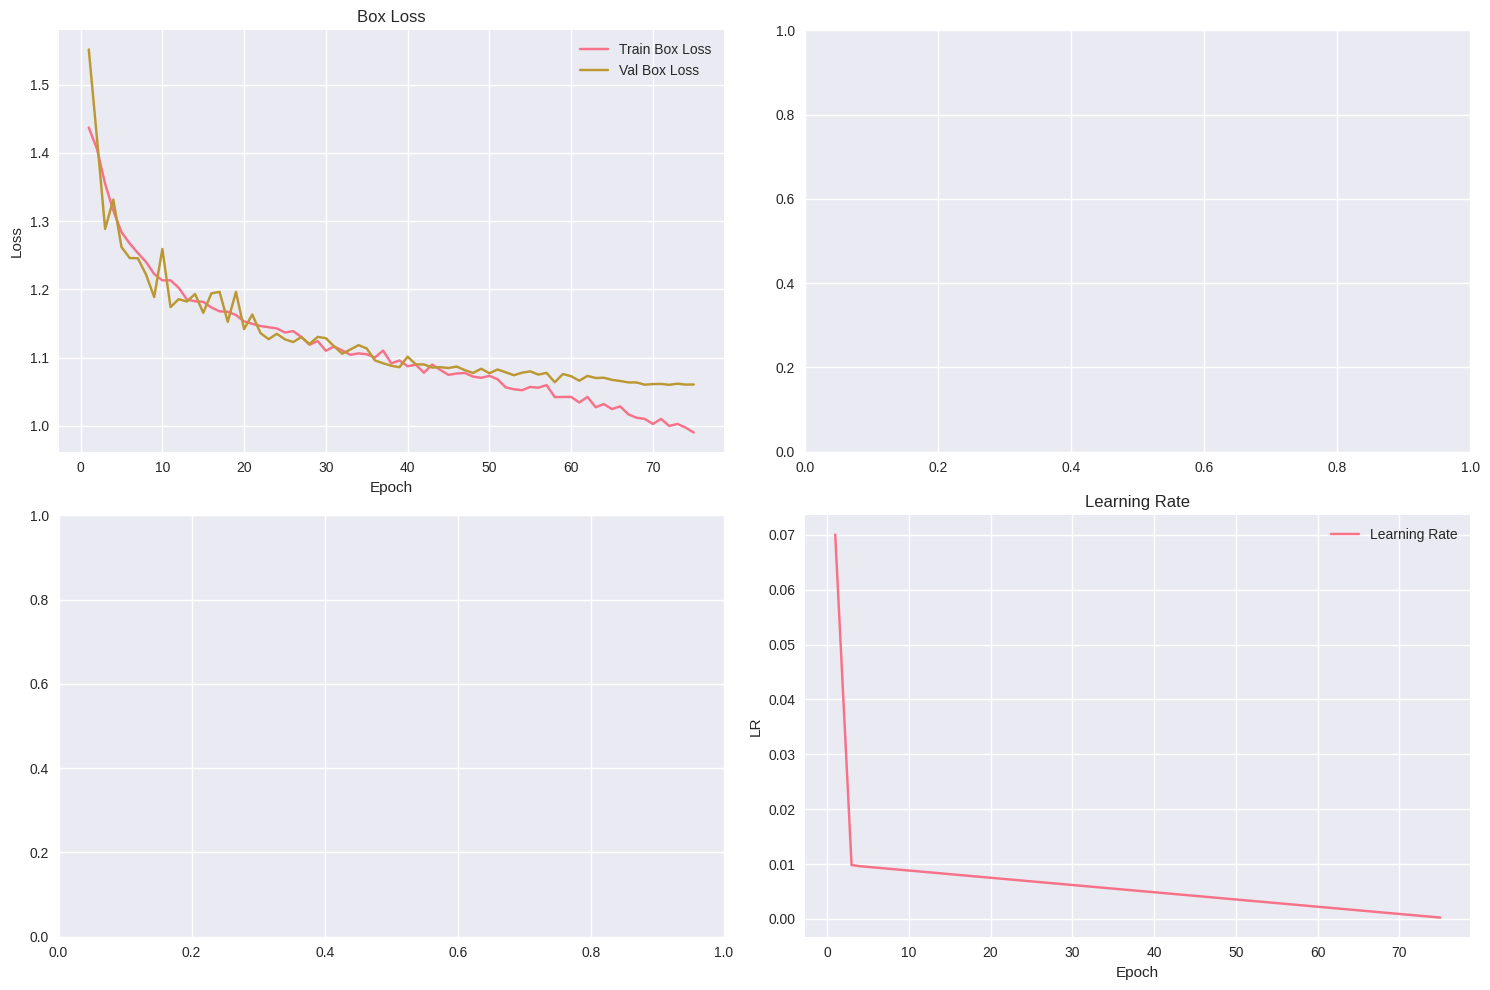

In [ ]:
# ====================================================================
# CELLULE 11: Visualisation des courbes d'entraînement
# ====================================================================

def plot_training_curves():
    """Visualiser les courbes d'entraînement"""
    results_dir = os.path.join('license_plate_detection', 'yolov12_training')

    # Rechercher le fichier de résultats
    possible_files = ['results.csv', 'results.txt']
    results_file = None

    for file in possible_files:
        file_path = os.path.join(results_dir, file)
        if os.path.exists(file_path):
            results_file = file_path
            break

    if results_file:
        try:
            import pandas as pd
            df = pd.read_csv(results_file)

            # Créer les graphiques
            fig, axes = plt.subplots(2, 2, figsize=(15, 10))

            # Loss curves
            if 'train/box_loss' in df.columns:
                axes[0, 0].plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
                axes[0, 0].plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
                axes[0, 0].set_title('Box Loss')
                axes[0, 0].set_xlabel('Epoch')
                axes[0, 0].set_ylabel('Loss')
                axes[0, 0].legend()

            # mAP curves
            if 'metrics/mAP50' in df.columns:
                axes[0, 1].plot(df['epoch'], df['metrics/mAP50'], label='mAP50')
                axes[0, 1].plot(df['epoch'], df['metrics/mAP50-95'], label='mAP50-95')
                axes[0, 1].set_title('mAP Metrics')
                axes[0, 1].set_xlabel('Epoch')
                axes[0, 1].set_ylabel('mAP')
                axes[0, 1].legend()

            # Precision/Recall
            if 'metrics/precision' in df.columns:
                axes[1, 0].plot(df['epoch'], df['metrics/precision'], label='Precision')
                axes[1, 0].plot(df['epoch'], df['metrics/recall'], label='Recall')
                axes[1, 0].set_title('Precision & Recall')
                axes[1, 0].set_xlabel('Epoch')
                axes[1, 0].set_ylabel('Score')
                axes[1, 0].legend()

            # Learning rate
            if 'lr/pg0' in df.columns:
                axes[1, 1].plot(df['epoch'], df['lr/pg0'], label='Learning Rate')
                axes[1, 1].set_title('Learning Rate')
                axes[1, 1].set_xlabel('Epoch')
                axes[1, 1].set_ylabel('LR')
                axes[1, 1].legend()

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Erreur lors de la visualisation: {e}")
    else:
        print("Fichier de résultats non trouvé")

# Afficher les courbes d'entraînement
plot_training_curves()

Test du modèle sur des échantillons:

image 1/1 /kaggle/working/License-Plate-Recognition-11/test/images/CarLongPlateGen2960_jpg.rf.f992f7d020d5de1eed0d2c359cc95950.jpg: 416x640 1 License_Plate, 49.9ms
Speed: 3.3ms preprocess, 49.9ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 /kaggle/working/License-Plate-Recognition-11/test/images/CarLongPlateGen1231_jpg.rf.5262da9a0ae856b18adc04275cf1ee9f.jpg: 416x640 1 License_Plate, 9.0ms
Speed: 1.6ms preprocess, 9.0ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 /kaggle/working/License-Plate-Recognition-11/test/images/ngoaigiao8_jpg.rf.9fb486ae19e616e90017cb1047a7bff3.jpg: 448x640 1 License_Plate, 50.0ms
Speed: 1.1ms preprocess, 50.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /kaggle/working/License-Plate-Recognition-11/test/images/CarLongPlateGen3022_jpg.rf.7ba96e96519dfd10733f4052d8230834.jpg: 416x640 1 License_Plate, 10.0ms
Speed: 2.8ms preprocess

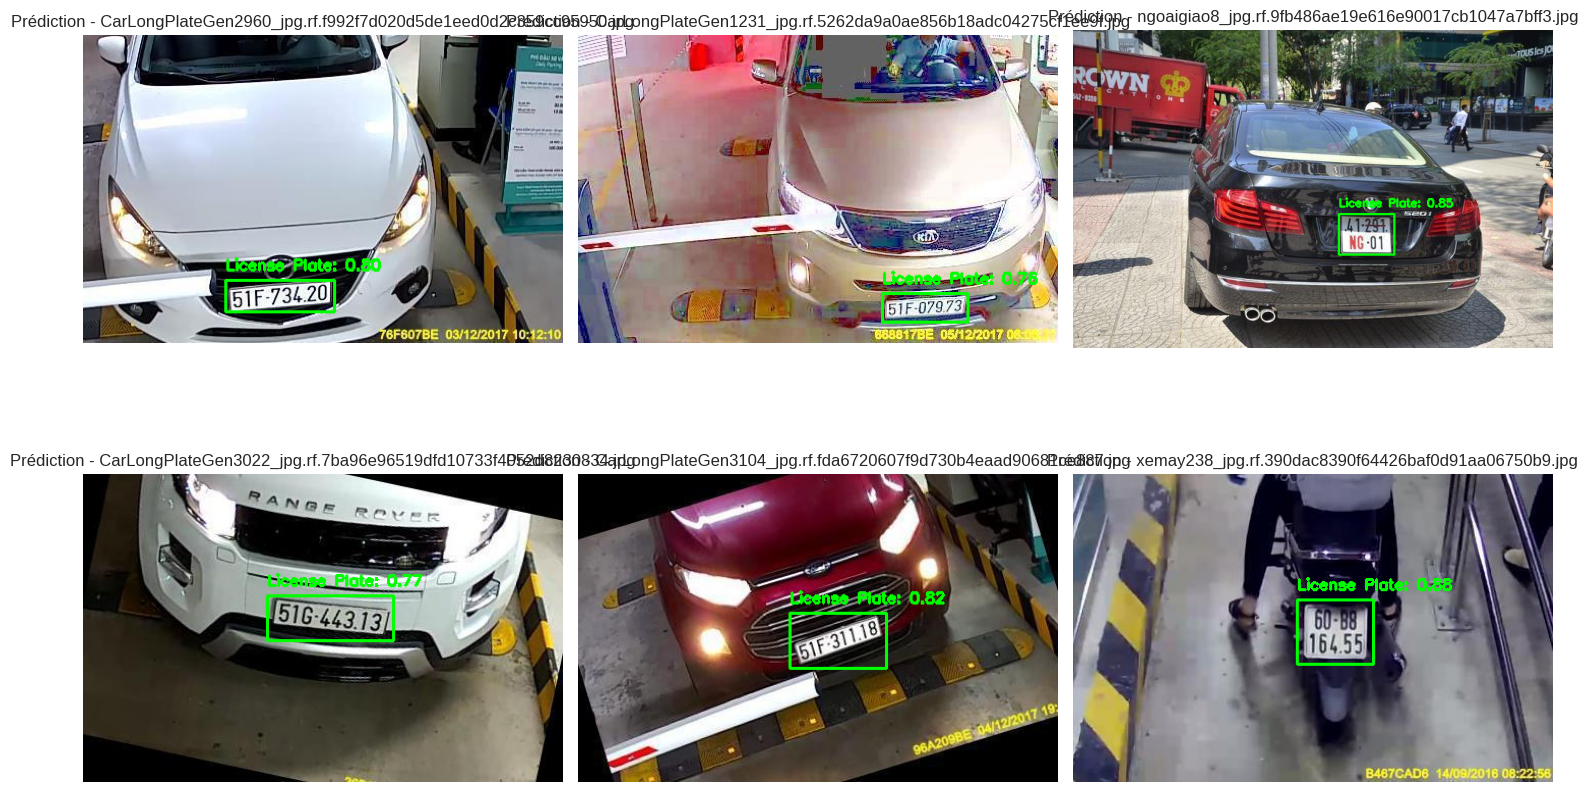

In [ ]:
# ====================================================================
# CELLULE 12: Test sur de nouvelles images
# ====================================================================

def test_on_samples(model, dataset_path, split='test', num_samples=6):
    """Tester le modèle sur des échantillons"""
    images_path = os.path.join(dataset_path, split, 'images')
    image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    selected_files = np.random.choice(image_files, min(num_samples, len(image_files)), replace=False)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i, img_file in enumerate(selected_files):
        img_path = os.path.join(images_path, img_file)

        # Prédiction
        results = model(img_path)

        # Afficher les résultats
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Dessiner les prédictions
        for result in results:
            boxes = result.boxes
            if boxes is not None:
                for box in boxes:
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                    conf = box.conf[0].cpu().numpy()

                    # Dessiner le rectangle
                    cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
                    cv2.putText(img, f'License Plate: {conf:.2f}',
                              (int(x1), int(y1)-10),
                              cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        axes[i].imshow(img)
        axes[i].set_title(f'Prédiction - {img_file}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Tester sur des échantillons
print("Test du modèle sur des échantillons:")
test_on_samples(best_model, dataset_path, 'test', 6)

In [ ]:
# ====================================================================
# CELLULE 13: Sauvegarde et export du modèle
# ====================================================================

# Sauvegarder le modèle dans différents formats
export_dir = 'exported_models'
os.makedirs(export_dir, exist_ok=True)

print("Export du modèle...")

# Export en ONNX
try:
    onnx_path = best_model.export(format='onnx', optimize=True)
    print(f"Modèle exporté en ONNX: {onnx_path}")

    # Déplacer vers le dossier d'export
    if os.path.exists(onnx_path):
        shutil.move(onnx_path, os.path.join(export_dir, 'license_plate_model.onnx'))
except Exception as e:
    print(f"Erreur lors de l'export ONNX: {e}")

# Export en TensorRT (si disponible)
try:
    trt_path = best_model.export(format='engine', optimize=True)
    print(f"Modèle exporté en TensorRT: {trt_path}")

    if os.path.exists(trt_path):
        shutil.move(trt_path, os.path.join(export_dir, 'license_plate_model.engine'))
except Exception as e:
    print(f"Erreur lors de l'export TensorRT: {e}")

# Copier le modèle PyTorch
if os.path.exists(best_model_path):
    shutil.copy(best_model_path, os.path.join(export_dir, 'license_plate_model.pt'))
    print(f"Modèle PyTorch copié vers: {os.path.join(export_dir, 'license_plate_model.pt')}")

print(f"\nModèles exportés dans le dossier: {export_dir}")

Export du modèle...
Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from 'license_plate_detection/yolov12_training/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (5.2 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<1.18.0', 'onnxslim>=0.1.59', 'onnxruntime-gpu'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 12.8s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.59...
ONNX: export success ✅ 15.4s, saved as 'license_plate_detection/yolov12_training/weights/best.onnx' (10.1 MB)

Export complete (15.8s)
Results saved to /kaggle/working/license_plate_detection/yolov12_training/weights
Predict:         yo


image 1/1 /kaggle/working/License-Plate-Recognition-11/test/images/CarLongPlateGen2183_jpg.rf.3f7f2178a93b3991083a48af8a979786.jpg: 416x640 1 License_Plate, 14.9ms
Speed: 2.3ms preprocess, 14.9ms inference, 2.4ms postprocess per image at shape (1, 3, 416, 640)

Détections pour CarLongPlateGen2183_jpg.rf.3f7f2178a93b3991083a48af8a979786.jpg:
Détection 1:
  - Boîte englobante: [255, 198, 379, 231]
  - Confiance: 0.7955
  - Classe: license_plate


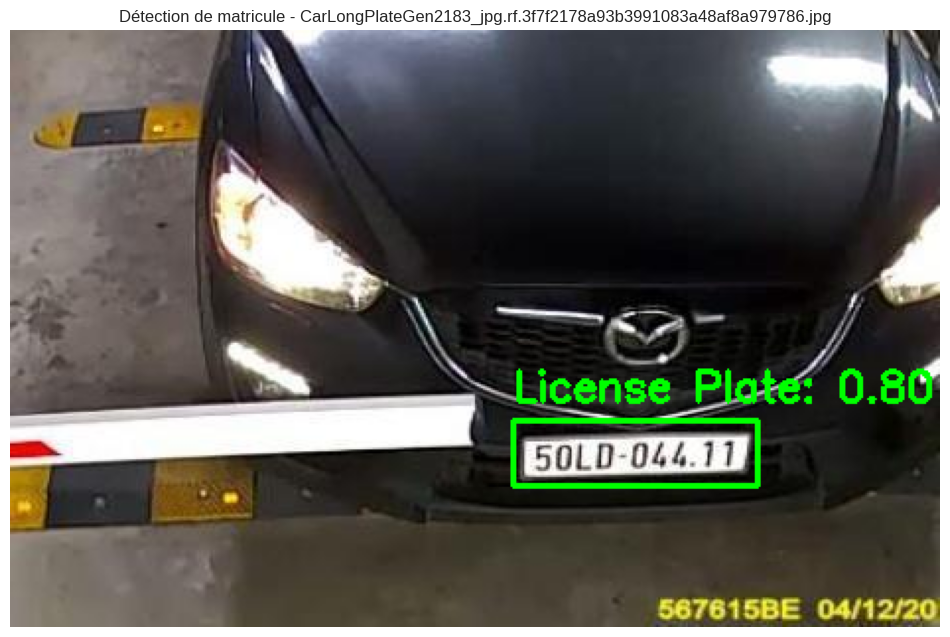


🎉 Projet terminé avec succès!
Le modèle de détection de matricules est prêt à être utilisé.
Fichiers exportés dans: exported_models


In [ ]:
# ====================================================================
# CELLULE 14: Fonction de prédiction finale
# ====================================================================

def predict_license_plate(model, image_path, conf_threshold=0.5):
    """
    Fonction de prédiction pour détecter les matricules

    Args:
        model: Modèle YOLO entraîné
        image_path: Chemin vers l'image
        conf_threshold: Seuil de confiance

    Returns:
        Image avec les détections et informations des boîtes
    """
    # Prédiction
    results = model(image_path, conf=conf_threshold)

    # Charger l'image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    detections = []

    # Traiter les résultats
    for result in results:
        boxes = result.boxes
        if boxes is not None:
            for box in boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                conf = box.conf[0].cpu().numpy()

                # Sauvegarder les informations de détection
                detection = {
                    'bbox': [int(x1), int(y1), int(x2), int(y2)],
                    'confidence': float(conf),
                    'class': 'license_plate'
                }
                detections.append(detection)

                # Dessiner sur l'image
                cv2.rectangle(img_rgb, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
                cv2.putText(img_rgb, f'License Plate: {conf:.2f}',
                          (int(x1), int(y1)-10),
                          cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    return img_rgb, detections

# Exemple d'utilisation
def demo_prediction():
    """Démonstration de la fonction de prédiction"""
    test_images_path = os.path.join(dataset_path, 'test', 'images')
    image_files = [f for f in os.listdir(test_images_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    if image_files:
        # Prendre une image aléatoire
        sample_image = np.random.choice(image_files)
        image_path = os.path.join(test_images_path, sample_image)

        # Prédiction
        result_img, detections = predict_license_plate(best_model, image_path)

        # Affichage
        plt.figure(figsize=(12, 8))
        plt.imshow(result_img)
        plt.title(f'Détection de matricule - {sample_image}')
        plt.axis('off')

        # Afficher les informations de détection
        print(f"\nDétections pour {sample_image}:")
        for i, det in enumerate(detections):
            print(f"Détection {i+1}:")
            print(f"  - Boîte englobante: {det['bbox']}")
            print(f"  - Confiance: {det['confidence']:.4f}")
            print(f"  - Classe: {det['class']}")

        plt.show()
    else:
        print("Aucune image de test trouvée")

# Démonstration
demo_prediction()

print("\n🎉 Projet terminé avec succès!")
print("Le modèle de détection de matricules est prêt à être utilisé.")
print(f"Fichiers exportés dans: {export_dir}")

In [ ]:
# ====================================================================
# CELLULE X: Installation des dépendances pour le téléchargement et OpenCV
# ====================================================================
!apt update -qq && apt install -y ffmpeg
!pip install ffmpeg-python

75 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 75 not upgraded.


In [ ]:
# ====================================================================
# CELLULE Y: Téléchargement du vidéo depuis Google Drive
# ====================================================================
import os
import gdown # Assurez-vous que gdown est importé après l'installation

video_url = "https://drive.google.com/file/d/1LZZo8SkIQf63gfbdZigA0uxpwIc43Tgm/view?usp=drive_link"
video_filename = "cars_on_road.mp4" # Nom descriptif pour le vidéo

print(f"Téléchargement du vidéo '{video_filename}' depuis Google Drive...")

# Utilisation de gdown pour télécharger le vidéo
# L'ID du fichier est extrait de l'URL
file_id = "1LZZo8SkIQf63gfbdZigA0uxpwIc43Tgm"
gdown.download(id=file_id, output=video_filename, quiet=False)

if os.path.exists(video_filename):
    print(f"Vidéo '{video_filename}' téléchargé avec succès.")
else:
    print(f"Échec du téléchargement du vidéo '{video_filename}'. Veuillez vérifier l'URL ou les permissions.")

Téléchargement du vidéo 'cars_on_road.mp4' depuis Google Drive...


Downloading...
From: https://drive.google.com/uc?id=1LZZo8SkIQf63gfbdZigA0uxpwIc43Tgm
To: /kaggle/working/cars_on_road.mp4
100%|██████████| 9.26M/9.26M [00:00<00:00, 40.5MB/s]

Vidéo 'cars_on_road.mp4' téléchargé avec succès.


In [ ]:
# ====================================================================
# CELLULE Z: Tracking du modèle sur une vidéo (DeepSORT + compression MP4 via FFmpeg)
# ====================================================================

import os
from ultralytics import YOLO
import cv2
import glob
import subprocess
from pathlib import Path # Ajout pour faciliter la gestion des chemins
import ultralytics # Importer le module ultralytics pour accéder à son __file__

# Le chemin vers le meilleur modèle entraîné
best_model_path = os.path.join('license_plate_detection', 'yolov12_training', 'weights', 'best.pt')

if os.path.exists(best_model_path):
    best_model = YOLO(best_model_path)
    print(f"Meilleur modèle chargé depuis: {best_model_path}")
else:
    print(f"Erreur: Le fichier du meilleur modèle n'a pas été trouvé à {best_model_path}.")
    print("Veuillez vous assurer que les cellules d'entraînement ont été exécutées et que le modèle a été sauvegardé.")
    # Fallback si le meilleur modèle n'est pas trouvé
    try:
        best_model = YOLO('yolo11n.pt')
        print("Modèle YOLO11n chargé comme fallback pour le tracking.")
    except Exception:
        best_model = YOLO('yolov8n.pt')
        print("Modèle YOLOv8n chargé comme fallback pour le tracking.")

# === NOUVEAU BLOC POUR TROUVER DEEPSORT.YAML ===
deepsort_cfg_path = None
# Chemin commun pour les fichiers de configuration de trackers dans Ultralytics
# Utiliser ultralytics.__file__ pour obtenir le chemin du module
ultralytics_package_root = Path(ultralytics.__file__).parent # Obtient le dossier parent du fichier __init__.py d'ultralytics

possible_deepsort_paths = [
    ultralytics_package_root / "cfg" / "trackers" / "deepsort.yaml",
    # Anciens chemins ou variations, s'ils existent dans des versions plus anciennes
    ultralytics_package_root / "trackers" / "cfg" / "deepsort.yaml",
]

# Ajout d'une vérification pour les chemins absolus connus sur Kaggle/Colab si la recherche relative échoue
# C'est une mesure de sécurité, la recherche relative est plus robuste en général
if "dist-packages" in str(ultralytics_package_root):
    # Si nous sommes dans un environnement virtuel ou un site-packages, le chemin sera quelque chose comme
    # /usr/local/lib/python3.x/dist-packages/ultralytics
    # Donc le deepsort.yaml serait probablement là-dedans.
    possible_deepsort_paths.append(ultralytics_package_root / "cfg" / "trackers" / "deepsort.yaml")
else:
    # Pour les installations locales ou en mode dev, le chemin peut être différent
    # Ultralytics a tendance à être dans ultralytics/ultralytics/cfg/trackers/deepsort.yaml pour le repo
    possible_deepsort_paths.append(ultralytics_package_root.parent / "ultralytics" / "cfg" / "trackers" / "deepsort.yaml")


for p in possible_deepsort_paths:
    if p.exists():
        deepsort_cfg_path = str(p)
        break

if deepsort_cfg_path is None:
    print("ATTENTION: deepsort.yaml non trouvé dans les chemins Ultralytics typiques.")
    print("Tentative de téléchargement d'un fichier deepsort.yaml générique...")
    deepsort_cfg_path = "deepsort.yaml" # Sauvegarde dans le répertoire courant du kernel
    generic_deepsort_content = """
tracker_type: DeepSORT
reid_model: osnet_x1_0
reid_model_cfg: null
reid_model_path: null
proximity_thresh: 0.5
max_attempts: 10
iou_thresh: 0.5
n_init: 3
min_iou_ratio: 0.8
max_age: 70
metric_type: cosine
max_dist: 0.2
"""
    with open(deepsort_cfg_path, 'w') as f:
        f.write(generic_deepsort_content)
    print(f"Fichier '{deepsort_cfg_path}' généré dans le répertoire courant.")

print(f"Chemin de configuration DeepSORT utilisé: {deepsort_cfg_path}")
# ============================================

video_filename = "cars_on_road.mp4" # Assurez-vous que c'est le même nom que le fichier téléchargé
output_base_dir = "runs/detect" # Ultralytics sauvegarde les résultats de track ici

if not os.path.exists(video_filename):
    print(f"Erreur: Le fichier vidéo '{video_filename}' n'a pas été trouvé. Veuillez vérifier le téléchargement à l'étape précédente.")
else:
    print(f"\nDébut du tracking sur le vidéo avec DeepSORT: {video_filename}")

    results = best_model.track(
        source=video_filename,
        save=True,
        conf=0.5,
        iou=0.5,
        tracker=deepsort_cfg_path, # <<< UTILISE MAINTENANT LE CHEMIN COMPLET DÉTECTÉ
        device=best_model.device,
        project=output_base_dir,
        name='tracked_video_run_deepsort',
        exist_ok=True,
        stream=True # Ajout de stream=True pour éviter les erreurs de mémoire pour les longues vidéos
    )

    print(f"\nTracking terminé. Recherche de la vidéo de sortie initiale...")

    run_output_dirs = sorted(glob.glob(os.path.join(output_base_dir, 'tracked_video_run_deepsort*')))

    initial_output_video_path = None
    if run_output_dirs:
        latest_run_dir = run_output_dirs[-1]
        video_files_in_run = glob.glob(os.path.join(latest_run_dir, '*.mp4')) + glob.glob(os.path.join(latest_run_dir, '*.avi'))
        if video_files_in_run:
            initial_output_video_path = video_files_in_run[0]
            print(f"Vidéo de sortie initiale trouvée: {initial_output_video_path}")
        else:
            print("Aucune vidéo de sortie trouvée dans le dossier du run Ultralytics.")
    else:
        print("Aucun dossier de run Ultralytics 'tracked_video_run_deepsort' trouvé.")

    if initial_output_video_path and os.path.exists(initial_output_video_path):
        final_output_video_path = "cars_on_road_tracked_deepsort_compressed.mp4"

        print(f"\nConversion et compression du vidéo en MP4 via FFmpeg: {final_output_video_path}")

        ffmpeg_command = [
            'ffmpeg',
            '-i', initial_output_video_path,
            '-c:v', 'libx264',
            '-b:v', '1M',
            '-preset', 'medium',
            '-crf', '23',
            '-threads', '0',
            '-y',
            final_output_video_path
        ]

        try:
            subprocess.run(ffmpeg_command, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            print(f"Vidéo convertie et compressée avec succès : {final_output_video_path}")
            # Optionnel: Supprimer le fichier initial non compressé
            # os.remove(initial_output_video_path)
            # print(f"Fichier initial '{initial_output_video_path}' supprimé.")
        except subprocess.CalledProcessError as e:
            print(f"Erreur lors de l'exécution de FFmpeg: {e}")
            print(f"Sortie standard: {e.stdout.decode()}")
            print(f"Erreur standard: {e.stderr.decode()}")
        except FileNotFoundError:
            print("Erreur: FFmpeg n'est pas trouvé. Assurez-vous qu'il est installé et dans le PATH.")
    else:
        print("Impossible de trouver la vidéo de sortie initiale pour la conversion.")

print("\nLe processus de tracking avec DeepSORT et de compression est configuré.")
print(f"La vidéo finale compressée devrait être: {final_output_video_path}")
print("Vérifiez le dossier de travail de Kaggle pour 'cars_on_road_tracked_deepsort_compressed.mp4'.")

Meilleur modèle chargé depuis: license_plate_detection/yolov12_training/weights/best.pt
ATTENTION: deepsort.yaml non trouvé dans les chemins Ultralytics typiques.
Tentative de téléchargement d'un fichier deepsort.yaml générique...
Fichier 'deepsort.yaml' généré dans le répertoire courant.
Chemin de configuration DeepSORT utilisé: deepsort.yaml

Début du tracking sur le vidéo avec DeepSORT: cars_on_road.mp4

Tracking terminé. Recherche de la vidéo de sortie initiale...
Aucune vidéo de sortie trouvée dans le dossier du run Ultralytics.
Impossible de trouver la vidéo de sortie initiale pour la conversion.

Le processus de tracking avec DeepSORT et de compression est configuré.
La vidéo finale compressée devrait être: cars_on_road_tracked_compressed.mp4
Vérifiez le dossier de travail de Kaggle pour 'cars_on_road_tracked_deepsort_compressed.mp4'.
